# Using Genex to identify marker genes

In [47]:
#from google.colab import drive
#drive.mount('/content/drive')


In [48]:
#import os
#os.chdir("/content/drive/My Drive/BIOML/HIMANI")

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from genex.filters.embedded import EmbeddedFilter
from genex.filters.mrmr import MRMRP
from genex.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs
from sklearn.feature_selection import RFE,RFECV, SelectKBest, f_classif,SelectKBest, mutual_info_classif,chi2
from genex.eval.evaluate import do_train_test
from genex.eval.cross_validation import  do_cross_validation_with_feature_selection,do_cross_validation

%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib inline

#from matplotlib.pyplot import plt
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
#mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

## Inputs and parameters

In [3]:
# ========== INPUTS ==========

mydata = 'GSE106608_norm'


data_file = './data/'+ mydata +'.csv'

deg_lf_file = './data/'+ mydata +'_DEGS.csv'
degs_file = './data/'+ mydata +'_DEGS.txt'   # If None, all genes will be considered.
out_file = './results/'+ mydata +'/fs_scores.csv'

is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
num_folds = 5 #2
num_runs = 5  #2
label = 'disease'

# feature selection
# num_features = 10 #20
# fsm = MRMRP(relevance_func= auc_relevance, redundancy_func=stats.pearsonr, num_features=num_features)

models = {
    "LinearSVC": LinearSVC(),
    "RidgeClassifier" : RidgeClassifier(alpha=1.0, max_iter=1000, solver='auto', tol=1e-3),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SGDClassifier" : SGDClassifier(loss="log_loss", penalty="l2", random_state=seed,learning_rate='optimal')
}


top_markers_to_viz = 10    # set to zero to visualize all potential markers. was 10

In [ ]:
if degs_file is not None and os.path.exists(degs_file):
    DEGs = load_DEGs(degs_file)
    # Keep only genes that exist in the dataframe columns
    DEGs = [gene for gene in DEGs if gene in df.columns]
    lenDEGs = len(DEGs)
    print(f"{lenDEGs} DEGs loaded and matched!")
else:
    lenDEGs = 0
    print("No DEGs provided or file not found. Pipeline will consider all genes.")

# def load_DEGs(path): if oen from simple text file. this will clean blanck space and blank lines
#     with open(path, 'r') as f:
#         return [line.strip() for line in f if line.strip()]


No DEGs provided or file not found. Pipeline will consider all genes.


In [11]:
df = pd.read_csv(data_file,low_memory=False)
df=df.set_index('GeneId')
df = df.transpose()

#df2 = pd.read_csv(deg_lf_file)


print('Shape of {0} is {1}'.format(data_file, df.shape))
theData = df
y = df[label]
df =df.drop([label],axis=1)
df.head()

Shape of ./data/GSE106608_norm.csv is (16, 18346)


GeneId,Gene_100287102,Gene_653635,Gene_102466751,Gene_100996442,Gene_729737,Gene_102725121,Gene_102723897,Gene_102465909,Gene_112268260,Gene_729759,...,Gene_4563,Gene_4537,Gene_4539,Gene_4538,Gene_4568,Gene_4540,Gene_4541,Gene_4556,Gene_4519,Gene_4571
GSM2843848,1.316889,3.440423,1.624622,1.767795,3.314412,1.485945,3.483799,1.702082,0.965042,2.046247,...,0.773491,2.853347,2.763542,3.703757,0.965042,3.655679,3.115309,2.187562,3.340300,1.436562
GSM2843849,1.651310,3.325132,1.504666,1.373957,3.160321,1.725183,3.328069,1.534408,1.141101,1.777484,...,1.116729,2.494369,2.507818,3.445614,1.034146,3.390673,2.821239,1.904710,3.115201,1.524718
GSM2843850,1.246739,3.195542,1.359980,1.224623,3.280541,1.421815,3.308169,1.556931,1.026915,1.359980,...,1.026915,2.613032,2.640878,3.545706,1.659835,3.439466,2.860234,1.911796,3.108534,1.546245
GSM2843851,1.535281,3.339974,1.493146,1.350373,3.110905,1.657042,3.340131,1.600415,1.284095,1.979307,...,0.987718,2.678244,2.769738,3.611432,0.987718,3.446003,2.951976,2.010650,3.266213,1.713837
GSM2843852,1.346531,3.125166,1.222988,1.541298,3.134025,1.541298,3.110339,1.262011,1.202077,1.941548,...,0.984110,2.567508,2.543785,3.456292,0.812823,3.337681,2.780108,1.909145,3.087244,1.202077


In [13]:
# Load and process data
df = pd.read_csv(data_file, low_memory=False)
df = df.set_index('GeneId').transpose()
print(f"Shape of {data_file} is {df.shape}")

y = df[label]

if lenDEGs > 0:
    df = df[DEGs]
else:
    df = df.drop([label], axis=1)

print(f"Shape (Within DEGs) of {data_file} is {df.shape}")
names = df.columns
X = df.values


Shape of ./data/GSE106608_norm.csv is (16, 18346)
Shape (Within DEGs) of ./data/GSE106608_norm.csv is (16, 18345)


In [14]:
# Normalize per sample?
if is_normalize_samples:
    X = norm_filter.fit_transform(X.T, y).T
    print('Samples Normalized..')
# Normalize per sample
elif is_normalize_columns:
    X = norm_filter.fit_transform(X, y)
    print('Genes Normalized..')
else:
    print('No normalization used..')

Genes Normalized..


ACC	Sn	Sp	MCC	AUC
[0.77333333 0.52       0.98       0.50618802 0.75      ]
ACC	Sn	Sp	MCC	AUC
[0.73       0.58       0.86       0.44928203 0.72      ]
ACC	Sn	Sp	MCC	AUC
[0.82       0.66       0.96       0.62618802 0.93      ]
ACC	Sn	Sp	MCC	AUC
[0.69333333 0.64       0.78       0.42618802 0.8       ]


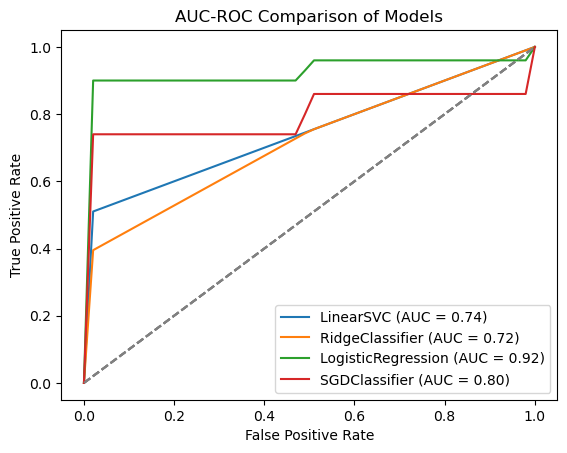

In [17]:
from sklearn.metrics import roc_curve, auc


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_name, model in models.items():
        tprs, aucs, mean_fpr = [], [], np.linspace(0, 1)
        fsm=RFE(estimator=model,n_features_to_select=20,step=200)
        res2,scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
        print('ACC\tSn\tSp\tMCC\tAUC')
        print(res2['metrics'])
        #print(res2)
        fpr = res2['fpr']
        tpr = res2['tpr']
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Comparison of Models')
    plt.legend()
    plt.show()


In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    res2, scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
    print('ACC\tSn\tSp\tMCC\tAUC')
    print(res2['metrics'])
    #print(scores)

    dict = {'feature': names, 'score': scores}
    df_score = pd.DataFrame(dict, columns=['feature', 'score'],index=None)
    df_score[df_score['score']>0].sort_values(by='score',ascending=False)


ACC	Sn	Sp	MCC	AUC
[0.69333333 0.64       0.78       0.42618802 0.8       ]


In [30]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume you already have these from before
# df = your dataframe with gene expression (samples x genes)
# y = label vector (same length as number of samples)
# names = list of gene names (column names of df)
# X = df.values (gene expression matrix)

# === 1. Train both models ===
sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
log = LogisticRegression(random_state=42, max_iter=1000)

sgd.fit(X, y)
log.fit(X, y)

# === 2. Get absolute coefficient scores for genes ===
sgd_scores = np.abs(sgd.coef_).flatten()
log_scores = np.abs(log.coef_).flatten()

# === 3. Normalize both scores between 0 and 1 ===
scaler = MinMaxScaler()
sgd_norm = scaler.fit_transform(sgd_scores.reshape(-1, 1)).flatten()
log_norm = scaler.fit_transform(log_scores.reshape(-1, 1)).flatten()

# === 4. Combine scores ===
combined_score = sgd_norm + log_norm

# === 5. Rank genes ===
top_indices = np.argsort(combined_score)[::-1]  # descending order
top_genes = [names[i] for i in top_indices]
top_scores = [combined_score[i] for i in top_indices]

# === 6. Display top N genes ===
N = 20
print(f"\nTop {N} Genes based on combined score:\n")
for i in range(N):
    print(f"{i+1:2d}. {top_genes[i]} — Score: {top_scores[i]:.4f}")



Top 20 Genes based on combined score:

 1. Gene_2213 — Score: 1.9241
 2. Gene_3712 — Score: 1.9084
 3. Gene_11326 — Score: 1.8675
 4. Gene_100289574 — Score: 1.8654
 5. Gene_10457 — Score: 1.8469
 6. Gene_11130 — Score: 1.7872
 7. Gene_353322 — Score: 1.7823
 8. Gene_26271 — Score: 1.7256
 9. Gene_54457 — Score: 1.7093
10. Gene_6531 — Score: 1.6940
11. Gene_56606 — Score: 1.6869
12. Gene_51117 — Score: 1.6844
13. Gene_102724127 — Score: 1.6807
14. Gene_54807 — Score: 1.6739
15. Gene_3835 — Score: 1.6691
16. Gene_1153 — Score: 1.6628
17. Gene_8635 — Score: 1.6616
18. Gene_102723753 — Score: 1.6405
19. Gene_8975 — Score: 1.6335
20. Gene_10613 — Score: 1.6303
